# ICBC话务数据分析
Weina Ma - January 24, 2018

## 发现
* 前7位号码相同，后四位有规律变化，频繁拨打，时长短。例如，联通号码前7位1552477，一天共拨打618次，后四位号码104个，每个号码拨打6次，每次时长6秒；后四位分别为4671 4673 4679 4681 4682 4685 4686 4690 4691 4698 4701 4702 4707 4708 4713 4717 4718...
* 前7位号码相邻，行为极相似。例如，联通号码前7位1552477，和前7位1552478的行为模式几乎一样

# 1. Load data ( rows x 26 columns)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np
import missingno as msno
%matplotlib inline
pd.set_option('display.max_rows',None)
pd.options.display.float_format = '{:.0f}'.format

#pd.set_option('display.max_colwidth',500)
df=pd.read_csv('/vagrant/gong_hang/201801/20180107.csv',encoding='gbk')
# 列出前五行
df.head()

ID      SRC_ADD  CALLING_NUM   VDN DIALED_NUM  DURATION  \
0  1759803603  80.14.28.10         4861 76315   9885025#        60   
1  1759803604  80.14.28.10  18734147633 76319       4714        60   
2  1759803605  80.14.28.10         4880 76319   9885030#        60   
3  1759803606  80.14.28.10  17809980556 76322       4710        42   
4  1759803607  80.14.28.10         4823 76322   9885037#        42   

   CALLING_DATE  CALLING_TIME COND_CODE  IN_TRK_CODE      ...        CALL_NUM  \
0         10718             1         7          nan      ...               3   
1         10718             1         9         4880      ...               1   
2         10718             1         7          nan      ...               3   
3         10718             1         9         4823      ...               1   
4         10718             1         7          nan      ...               3   

   CALL_TYPE  CHARGE_RULE_ID  COST         CALL_DATE           CRE_DATE  \
0          2               0     0  2018/1/7 0:01:00  2018/1/16 5:28:09   
1          1               0     0  2018/1/7 0:01:00  2018/1/16 5:28:09   
2          2               0     0  2018/1/7 0:01:00  2018/1/16 5:28:09   
3          1               0     0  2018/1/7 0:01:00  2018/1/16 5:28:09   
4          2               0     0  2018/1/7 0:01:00  2018/1/16 5:28:09   

   MAKER_NAME    ADDRESS  MOBILE_MAKER_NAME  PROVINCE_NAME  
0    IP Trunk  SIP中继(思科）                NaN            NaN  
1    IP Trunk       山西-2                 移动             山西  
2    IP Trunk  SIP中继(思科）                NaN            NaN  
3    IP Trunk         新疆                 移动             山西  
4    IP Trunk  SIP中继(思科）                NaN            NaN  

[5 rows x 26 columns]

In [2]:
# (行数, 列数)
df.shape

(983023, 26)

# 2. Filter data(数据清洗)

- 分析通话为主叫
- 号码为手机、座机、IP电话
- 关注的呼入中继（IN_TRK_CODE）号
- 排除6个手机号码，这6个号码其它系统进行工行拨测使用号码

In [3]:
# filter dailed out & 95588 & area_code + 95588
df = df[(df['CALL_TYPE'] == 1) & \
        (df['CALLING_NUM']/1000000 >= 1) & ((df['CALLING_NUM']%100000 != 95588) | (df['CALLING_NUM']/100000000 >= 1))]

# filter test numbers
df = df[df['CALLING_NUM'].isin([18210261957, 18210261795, 17343195721, \
                               17718332497, 13263105230, 13263103918]) == False]

# filter IN_TRK_CODE
df = df[df['IN_TRK_CODE'].isin([4860,4881,4815,4816,4834,4873,4878,4899,4820,4862,\
                                4849,4850,4828,4827,4858,4859,4840,4829,4848,4830,\
                                4831,4832,4833,4847,4854,4705,4706,4707,4708,4709,\
                                4710,4711,4712,4713,4714,4855,4715,4716,4717,4718,\
                                4719,4720,4721,4722,4723,4724,4856,4725,4726,4727,\
                                4728,4729,4730,4731,4732,4733,4857,4700,4701,4702,\
                                4703,4704,4872,4804,4894,4801,4898,4821,4805,4897,\
                                4806,4802,4892,4893,4890,4861,4870,4826,4885,4886,\
                                4810,4811,4852,4853,4880,4879,4807,4823,4876,4877,\
                                4808,4803,4812])]

df.shape

(328966, 26)

In [5]:
# Missing values
df.isnull().sum()

ID                        0
SRC_ADD                   0
CALLING_NUM               0
VDN                       0
DIALED_NUM                0
DURATION                  0
CALLING_DATE              0
CALLING_TIME              0
COND_CODE                 0
IN_TRK_CODE               0
FRL                       0
IN_CRT_ID            328966
CODE_USED            328966
MAKER                     0
CIRCUIT_TYPE              0
CALLERLOC             24154
CALL_NUM                  0
CALL_TYPE                 0
CHARGE_RULE_ID            0
COST                      0
CALL_DATE                 0
CRE_DATE                  0
MAKER_NAME                9
ADDRESS                   0
MOBILE_MAKER_NAME     31617
PROVINCE_NAME         31617
dtype: int64

## 列出每个类别top10号码

In [6]:
df['HOURS'] = df['CALLING_TIME'].apply(lambda x:abs(x) / 100 )

#移动
df_y = df[(df['CALLING_NUM']/100000000).astype(int).isin([134,135,136,137,138,139,147,150,151,152,157,159,182,183,187,188,172,178,184,198,148])]
print "=====China mobile："
print df_y.shape
print len(df_y["CALLING_NUM"].unique())
print df_y["CALLING_NUM"].value_counts().nlargest(10)
#联通
df_l = df[(df['CALLING_NUM']/100000000).astype(int).isin([130,131,132,145,155,156,186,171,175,176,185,166,146])]
print "=====China Unicom:" 
print df_l.shape
print len(df_l["CALLING_NUM"].unique())
print df_l["CALLING_NUM"].value_counts().nlargest(10)
#电信
df_d = df[(df['CALLING_NUM']/100000000).astype(int).isin([133,153,180,189,149,173,177,181,199])]
print "=====China Telecommunications:"
print df_d.shape
print len(df_d["CALLING_NUM"].unique())
print df_d["CALLING_NUM"].value_counts().nlargest(10)
#others
print "=====Others:"
df_g = df[(df['CALLING_NUM']/100000000).astype(int).isin([134,135,136,137,138,139,147,150,151,152,157,159,182,183,187,188,172,178,184,198,148,\
                                                         130,131,132,145,155,156,186,171,175,176,185,166,146,\
                                                         133,153,180,189,149,173,177,181,199]) == False]
print df_g.shape
print len(df_g["CALLING_NUM"].unique())
print df_g["CALLING_NUM"].value_counts().nlargest(10)

=====China mobile：
(173320, 27)
116711
18841701593    79
15236646257    53
13838665536    50
13993286757    32
15064521239    30
15729037017    28
13759677909    26
18702277700    25
18845152946    23
13600918329    22
Name: CALLING_NUM, dtype: int64
=====China Unicom:
(82390, 27)
54916
15659680980    44
13198235721    42
13259939729    40
17129503063    39
18561507251    37
17696646827    37
13072610405    35
17152102263    32
17152102258    28
17163237176    27
Name: CALLING_NUM, dtype: int64
=====China Telecommunications:
(51838, 27)
35098
17750180597    90
18166113507    85
17750764450    32
13364390036    25
18161561418    20
17704770185    19
15314177199    17
18993509067    17
18999941743    17
13314711825    16
Name: CALLING_NUM, dtype: int64
=====Others:
(21418, 27)
13955
3553368009     45
3517893773     35
2472853935     34
9128153985     33
9518646912     31
15865258045    30
37962903605    24
53284688617    24
3735266118     19
4595835737     19
Name: CALLING_NUM, dtype: in

## 联通号码分割成（前7位，后4位），并列出top10前7位

In [105]:
#联通 df_l
df_l['first7'] = df_l['CALLING_NUM'].apply(lambda x:abs(int(x)) / 10000 )
df_l['last4'] = df_l['CALLING_NUM'].apply(lambda x:abs(int(x)) % 10000 )
#df_l.head()
print(len(df_l["first7"].unique()))
print df_l["first7"].value_counts().nlargest(10)

23984
1552477    618
1552478    537
1852577    147
1764565    137
1563820    133
1766757    118
1850426    102
1854344    100
1318300     94
1561781     87
Name: first7, dtype: int64


/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                ID      SRC_ADD  CALLING_NUM   VDN DIALED_NUM  DURATION  \
506097  1761623574  80.14.28.10  15524770200 76307       4700        60   
667807  1762407214  80.14.28.10  15524770200 76307       4700        48   
950745  1763486983  80.14.28.10  15524771200 76307       4700       426   
214600  1760554192  80.14.28.10  15524774662 76307       4700         6   
210267  1760551298  80.14.28.10  15524774662 76307       4700         6   

        CALLING_DATE  CALLING_TIME COND_CODE  IN_TRK_CODE  ...    COST  \
506097         10718          1437         9         4872  ...       0   
667807         10718          1706         9         4872  ...       0   
950745         10718          2251         9         4872  ...       0   
214600         10718          1103         9         4872  ...       0   
210267         10718          1102         9         4872  ...       0   

                CALL_DATE            CRE_DATE  MAKER_NAME  ADDRESS  \
506097  2018/1/7 14:37:00  2018/1/

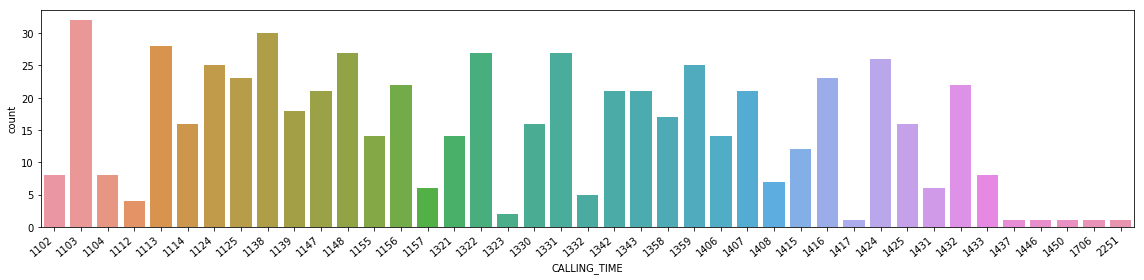

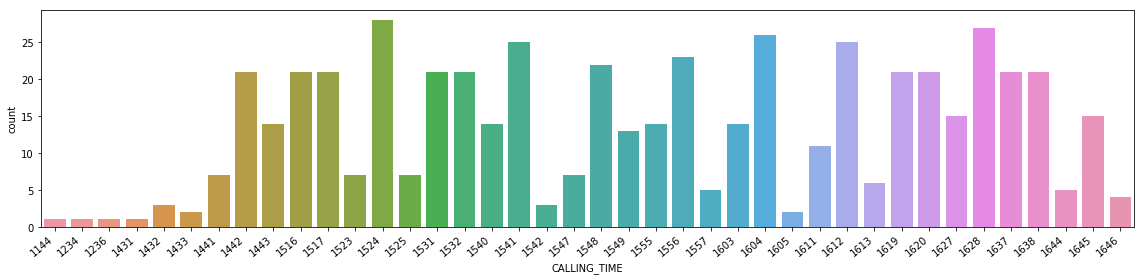

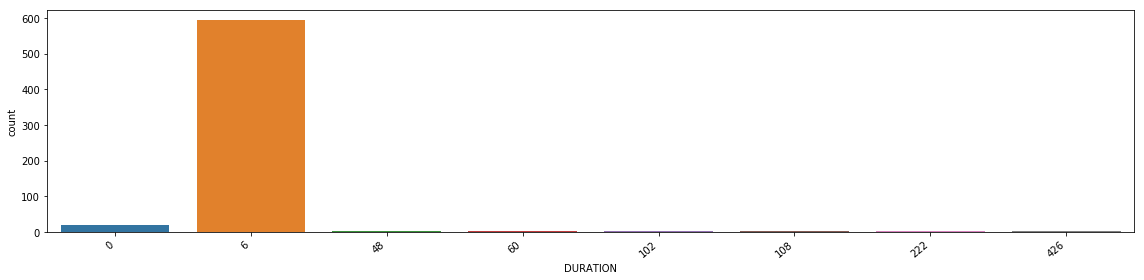

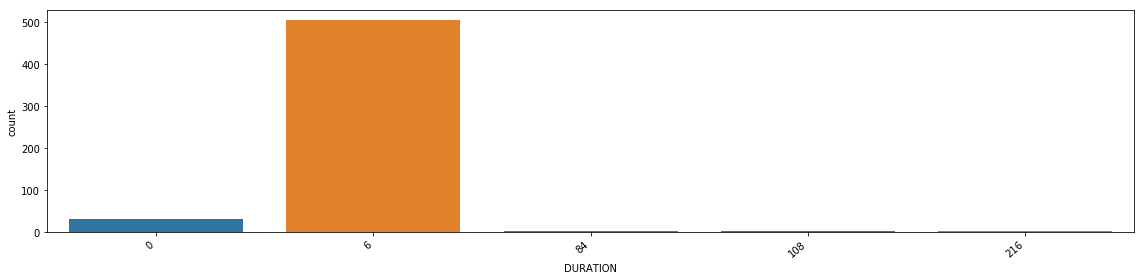

In [103]:
#df1 = df_l[df_l["first7"].isin([1552477,1552478])]
df1 = df_l[df_l["first7"].isin([1552477])]
df2 = df_l[df_l["first7"].isin([1552478])]
df1=df1.sort_values(['last4'])
df2=df2.sort_values(['last4'])
print df1.head()
print df2.head()
print(len(df1["last4"].unique()))
print(len(df2["last4"].unique()))
print df1["last4"].unique()
print df2["last4"].unique()
print df1["last4"].value_counts()
print df2["last4"].value_counts()

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="CALLING_TIME", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="CALLING_TIME", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="DURATION", data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()

plt.pyplot.figure(figsize=(16,4))
ax = sns.countplot(x="DURATION", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.pyplot.tight_layout()
plt.pyplot.show()
